In [127]:
# Importing necessary libraries
import numpy as np
import scipy as scp
from scipy.interpolate import make_interp_spline, BSpline
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from timeit import default_timer as timer
from tabulate import tabulate

## **Matrix Multiplication Algorithms**

- ### Naive algorithm

The following code was taken from the Notebook: "Notebook para decomposição LU e forma escalonada" available in the Materials of the 2024 Linear Algebra and Applications course accessed via the link: https://w3.impa.br/~jpereira

In [128]:
# Function for manual matrix multiplication
def manual_matrix_multiplication(A, B):
    m, n = A.shape
    n_, p = B.shape
    
    if n != n_:
        print("Incompatible matrices. Can't perform multiplication.")
        return
    
    # Create the result matrix and fill it with zeros
    result = np.zeros((m, p))

    # Performing matrix multiplication
    for i in range(m): # iterate over rows
        for j in range(p): # iterate over columns
            for k in range(n): # summing over all k
                result[i, j] += A[i, k] * B[k, j]
    
    return result


- ### Strassen's algorithm

The following code was adapted from the reference: https://www.geeksforgeeks.org/strassens-matrix-multiplication/

In [129]:
# Function for divide a matrix M (nxn) in 4 submatrix (n/2 x n/2)
def divide(M):
    row, col = M.shape
    row2,col2 = row//2, col//2
    return M[:row2, :col2], M[:row2, col2:], M[row2:, :col2], M[row2:, col2:]

# Function to insert the final elements in the rows and columns
def combine_matrices(C11, C12, C21, C22):
    top = np.concatenate((C11, C12), axis=1)
    bottom = np.concatenate((C21, C22), axis=1)
    return np.concatenate((top, bottom), axis=0)

# Function for strassen matrix multiplication
def strassen_matrix_multiplication(A, B):
	"""
	Computes matrix product by divide and conquer approach, recursively.
	Input: nxn matrices A and B
	Output: nxn matrix, product of A and B
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B

	# Splitting the matrices into quadrants. This will be done recursively
	# until the base case is reached.
	a, b, c, d = divide(A)
	e, f, g, h = divide(B)

	# Computing the 7 products, recursively (p1, p2...p7)
	p1 = strassen_matrix_multiplication(a, f - h) 
	p2 = strassen_matrix_multiplication(a + b, h)	 
	p3 = strassen_matrix_multiplication(c + d, e)	 
	p4 = strassen_matrix_multiplication(d, g - e)	 
	p5 = strassen_matrix_multiplication(a + d, e + h)	 
	p6 = strassen_matrix_multiplication(b - d, g + h) 
	p7 = strassen_matrix_multiplication(a - c, e + f) 

	# Computing the values of the 4 quadrants of the final matrix c
	c11 = p5 + p4 - p2 + p6 
	c12 = p1 + p2		 
	c21 = p3 + p4		 
	c22 = p1 + p5 - p3 - p7 

	# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
	C = combine_matrices(c11, c12, c21, c22)

	return C

## **Preliminar study**

- Small matrices

Initialy was perfomed some test with the standart Strassen algorithm to analyze its perfomance to small dimension matrices.

In [141]:
def size_time(method,n):
    # Time and run the determinant function
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)

    start_time = timer()
    mult = method(A,B)
    end_time = timer()
    return end_time - start_time

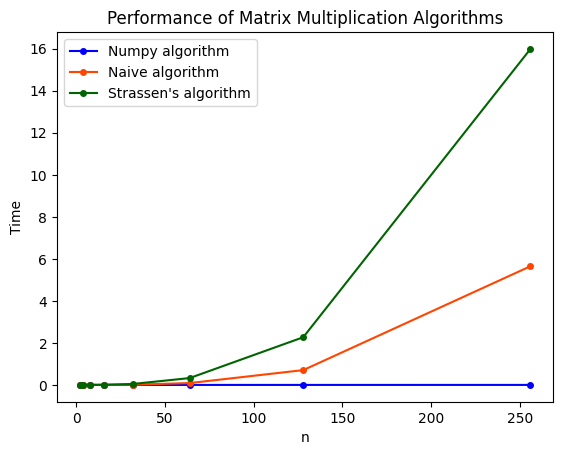

In [143]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
plt.plot(x, y1, label="Numpy algorithm", linestyle='-', color='Blue',marker='o', markersize=4) 

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
plt.plot(x, y2, label="Naive algorithm", linestyle='-', marker='o', color='OrangeRed', markersize=4) 

y3 = [size_time(strassen_matrix_multiplication,n) for n in ns] 
plt.plot(x,y3, label="Strassen's algorithm", color='DarkGreen',linestyle='-', markersize=4, marker='o')
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

The code below is made to smoothing the graph, since the function are of order O(n^3) e O(n^2.8).

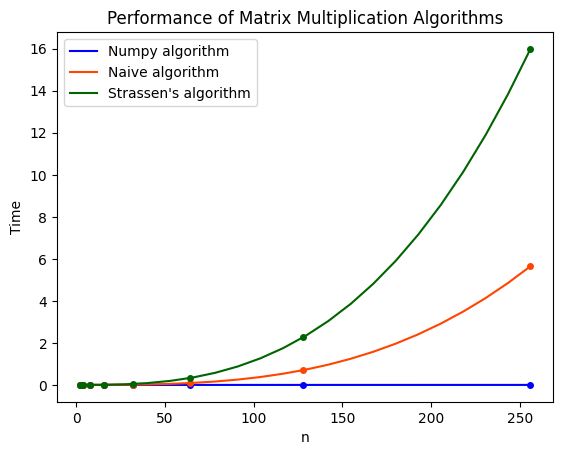

In [144]:
# Adapting the graphic, building interpolated splines to represent the cubic/almost cubic funcions
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 

tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)
plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-', color='OrangeRed', markersize=4) 

tck, u = interpolate.splprep([x,y3],s=0)
unew = np.arange(0,1.05,0.05)
out = interpolate.splev(unew,tck)
plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out[0],out[1], label="Strassen's algorithm", linestyle='-', color='DarkGreen', markersize=4) 
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

This datas also are shown in the table below:

In [145]:
# Creating a table with comparative data n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╕
│ Method   │ n = 2     │ n = 4      │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256     │
╞══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╡
│ Numpy    │ 8.42e-05s │ 3.7e-06s   │ 4.73e-05s  │ 6.96e-05s  │ 1.14e-05s  │ 2.56e-05s  │ 0.0001609s │ 0.0005038s  │
├──────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Naive    │ 8e-06s    │ 2.65e-05s  │ 0.000189s  │ 0.0014728s │ 0.0110164s │ 0.0881126s │ 0.7044145s │ 5.6495253s  │
├──────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Strassen │ 3.08e-05s │ 0.0001465s │ 0.0009607s │ 0.006616s  │ 0.045999s  │ 0.3260022s │ 2.2692927s │ 15.9899965s │
╘══════════╧═══════════╧════════════╧════════════╧════════════╧═

## **Study to optimize the algorithm**

- ### Strassen's optimized algorithm

This section is destined to apply a techinique to optimize the Strassen's standart algorithm.

In [161]:
# Function for strassen matrix multiplication
def strassen_optimized(A, B, crossover_point=64):
	"""
	Computes matrix product by divide and conquer approach, recursively. However, in small matrices uses the Naive Method.
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)
	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)
	

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized(a, f - h, crossover_point) 
		p2 = strassen_optimized(a + b, h, crossover_point)	 
		p3 = strassen_optimized(c + d, e, crossover_point)	 
		p4 = strassen_optimized(d, g - e, crossover_point)	 
		p5 = strassen_optimized(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized(b - d, g + h, crossover_point) 
		p7 = strassen_optimized(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

Strassen's optimized algorithm tests fo matrix 2^n x 2^n, with n between 1 and 11.

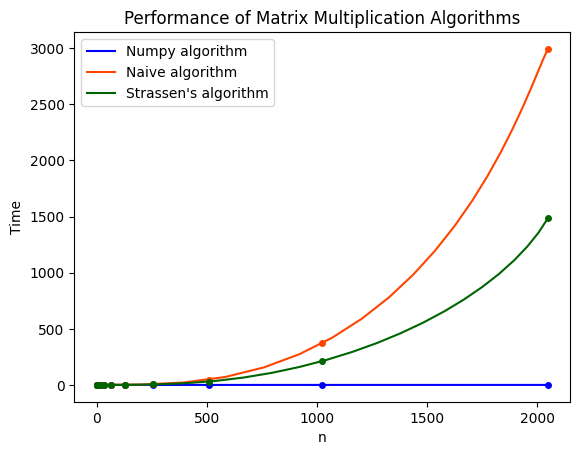

In [181]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 


y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)
plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-',  color='OrangeRed', markersize=4) 


y3 = [size_time(strassen_optimized,n) for n in ns] 
tck3, u3 = interpolate.splprep([x,y3],s=0)
unew3 = np.arange(0,1.05,0.05)
out3 = interpolate.splev(unew3,tck3)
plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out3[0], out3[1], label="Strassen's algorithm", linestyle='-',  color='DarkGreen', markersize=4) 
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show()    

In [182]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤══════════════╤═══════════════╕
│ Method   │ n = 2     │ n = 4     │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256    │ n = 512     │ n = 1024     │ n = 2048      │
╞══════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪══════════════╪═══════════════╡
│ Numpy    │ 0.000103s │ 9.84e-05s │ 4.1e-06s   │ 2.1e-06s   │ 6.2e-06s   │ 2.11e-05s  │ 0.0002081s │ 0.000316s  │ 0.0016524s  │ 0.010224s    │ 0.0728821s    │
├──────────┼───────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼──────────────┼───────────────┤
│ Naive    │ 8.9e-06s  │ 2.8e-05s  │ 0.0001982s │ 0.001524s  │ 0.0112352s │ 0.0880895s │ 0.7172765s │ 5.728146s  │ 47.1708207s │ 371.6901308s │ 2994.1421969s │
├──────────┼───────────┼───────────┼────

Strassen's optimized algorithm with crossover-point of 32.

In [184]:
# Function for strassen matrix multiplication
def strassen_optimized_32(A, B, crossover_point=32):
	"""
	Computes matrix product by divide and conquer approach, recursively. However, in small matrices uses the Naive Method.
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)
	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)
	

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized_32(a, f - h, crossover_point) 
		p2 = strassen_optimized_32(a + b, h, crossover_point)	 
		p3 = strassen_optimized_32(c + d, e, crossover_point)	 
		p4 = strassen_optimized_32(d, g - e, crossover_point)	 
		p5 = strassen_optimized_32(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized_32(b - d, g + h, crossover_point) 
		p7 = strassen_optimized_32(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

Strassen's optimized algorithm tests with crossover-point of 32.

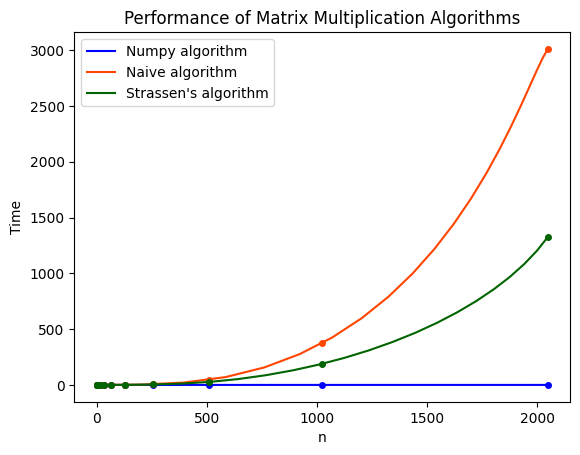

In [185]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 


y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)
plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-',  color='OrangeRed', markersize=4) 


y3 = [size_time(strassen_optimized_32,n) for n in ns] 
tck3, u3 = interpolate.splprep([x,y3],s=0)
unew3 = np.arange(0,1.05,0.05)
out3 = interpolate.splev(unew3,tck3)
plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out3[0], out3[1], label="Strassen's algorithm", linestyle='-',  color='DarkGreen', markersize=4) 
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show()    

In [186]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤══════════════╤═══════════════╕
│ Method   │ n = 2     │ n = 4     │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256    │ n = 512     │ n = 1024     │ n = 2048      │
╞══════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪══════════════╪═══════════════╡
│ Numpy    │ 5.43e-05s │ 5.1e-06s  │ 2.14e-05s  │ 3.6e-06s   │ 1.39e-05s  │ 2.78e-05s  │ 0.0006752s │ 0.0004614s │ 0.0018314s  │ 0.0143284s   │ 0.0712725s    │
├──────────┼───────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼──────────────┼───────────────┤
│ Naive    │ 1e-05s    │ 2.81e-05s │ 0.0001981s │ 0.0015149s │ 0.0113322s │ 0.0885044s │ 0.7064231s │ 5.6952118s │ 46.1964944s │ 374.9315111s │ 3011.2253078s │
├──────────┼───────────┼───────────┼────

- ### Strassen's algorithm to matrix of any size

In [166]:
def pad_matrix(A):
    n = len(A)
    # Determine the next power of 2
    next_power_of_2 = 1 << (n - 1).bit_length()
    padded_A = np.zeros((next_power_of_2, next_power_of_2), dtype=A.dtype)
    padded_A[:n, :n] = A
    return padded_A

def strassen_optimized_padding(A, B, crossover_point=64):
	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)

	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		A = pad_matrix(A)
		B = pad_matrix(B)

		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized_padding(a, f - h, crossover_point) 
		p2 = strassen_optimized_padding(a + b, h, crossover_point)	 
		p3 = strassen_optimized_padding(c + d, e, crossover_point)	 
		p4 = strassen_optimized_padding(d, g - e, crossover_point)	 
		p5 = strassen_optimized_padding(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized_padding(b - d, g + h, crossover_point) 
		p7 = strassen_optimized_padding(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

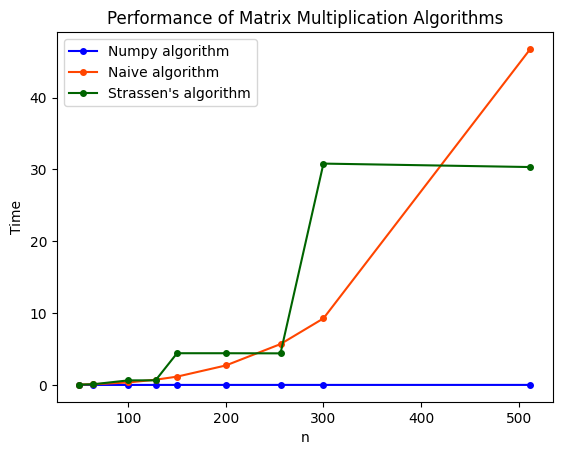

In [172]:
ns = [50,64,100,128,150,200,256,300,512]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
plt.plot(x, y1, label="Numpy algorithm", linestyle='-', color='Blue',marker='o', markersize=4) 

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
plt.plot(x, y2, label="Naive algorithm", linestyle='-', marker='o', color='OrangeRed', markersize=4) 

y3 = [size_time(strassen_optimized_padding,n) for n in ns] 
plt.plot(x,y3, label="Strassen's algorithm", color='DarkGreen',linestyle='-', markersize=4, marker='o')
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

In [174]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤═════════════╕
│ Method   │ n = 50     │ n = 64     │ n = 100    │ n = 128    │ n = 150    │ n = 200    │ n = 256    │ n = 300     │ n = 512     │
╞══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪═════════════╡
│ Numpy    │ 2.7e-05s   │ 4.18e-05s  │ 0.0002746s │ 0.0001826s │ 0.0009333s │ 0.0005362s │ 0.0009206s │ 0.0007092s  │ 0.0019853s  │
├──────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ Naive    │ 0.0488131s │ 0.0893558s │ 0.3437249s │ 0.7246743s │ 1.1521812s │ 2.7092319s │ 5.6836909s │ 9.2582562s  │ 46.7668375s │
├──────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ Strassen │ 0.0461481s │ 0.0924928s │ 0.6304817s │ 0.639866s  │ 4.4118367s 

In [173]:
#Diferences
A = np.random.rand(2**3, 2**3)
B= np.random.rand(2**3, 2**3)

manual_result = manual_matrix_multiplication(A,B)
strassen_result = strassen_matrix_multiplication(A,B)

max(abs((manual_result-strassen_result).min()), abs((manual_result-strassen_result).max()))

6.439293542825908e-15